<a href="https://colab.research.google.com/github/bingsen-wang/PowerElectronics/blob/main/Rectifier_1phaseFullBridge_diode.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<center><h1><b>Single-Phase Full-Brdige Diode Rectifier</h1></b>

Dr. Bingsen Wang

3/23/2024
</center>

#Python Code
The Python code illustrates waveforms of the 1-phase full-bridge diode rectifier.

<ipython-input-41-b8a618f448c3>:234: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


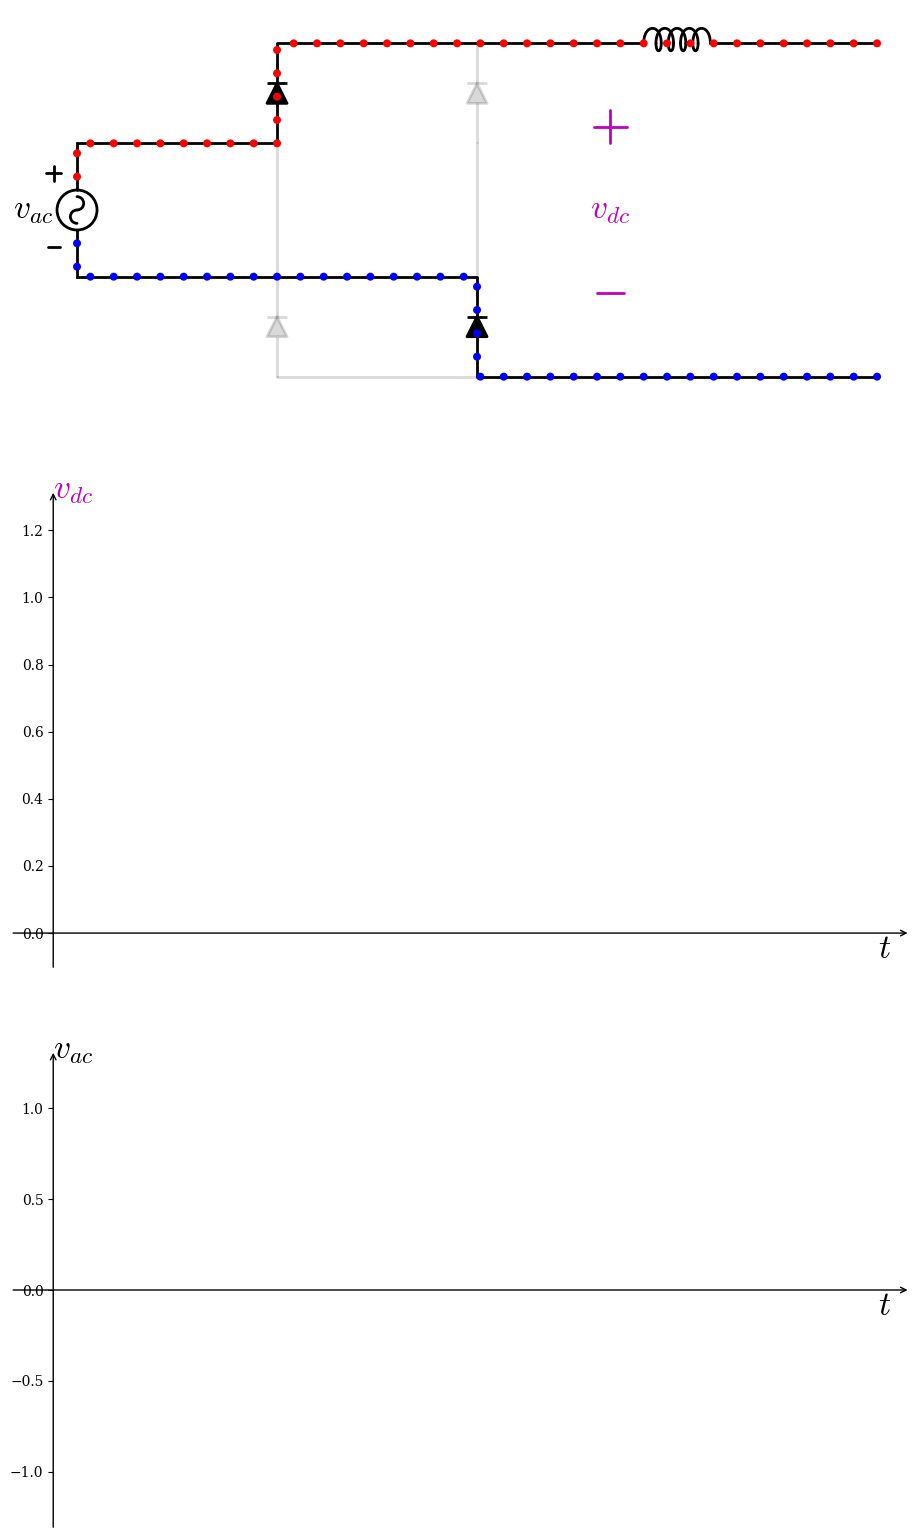

In [41]:
import matplotlib
from os import linesep
import numpy as np
from numpy import linspace,cos,sin,pi,heaviside,fft,array,sqrt
import matplotlib.pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.path import Path
import matplotlib.patches as mp
from matplotlib.collections import PatchCollection
from matplotlib import animation,rc,transforms
rc('animation', html='jshtml')
plt.rcParams.update({"font.family" : "serif","mathtext.fontset" : "cm"})

#modulation functions
def mf(t,f):
  mt = cos(2*pi*f*t)
  return mt

#switching functions for the high-side diodes
def hh(mt):
  ht = heaviside(mt,0)
  return ht

#switching functions for the low-side diodes
def hl(mt):
  ht = heaviside(-mt,0)
  return ht

#draw diode symbol
def drawDiode(ax,x0,y0,h,theta,lw,color):
  codes=[Path.MOVETO,Path.LINETO]
  p1=mp.PathPatch(Path([(x0,y0),(x0,y0+h*0.4), (x0,y0+h*0.6),(x0,y0+h)],
                       codes+codes))
  p2=mp.PathPatch(Path([(x0-h*0.1,y0+h*0.6),(x0+h*0.1,y0+h*0.6)],
                       codes)) #cathode
  p3=mp.PathPatch(Path([(x0,y0+h*0.6),(x0-h*0.1,y0+h*0.4),(x0+h*0.1,y0+h*0.4),(x0,y0+h*0.6)],
                       [Path.MOVETO,Path.LINETO,Path.LINETO,Path.CLOSEPOLY])) #anode
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  kwargs=dict({'ec':color,'fc':['none','none',color],'lw':lw,'transform':rot})
  ax.add_collection(PatchCollection([p1,p2,p3],**kwargs))
  return

#draw inductor symbol
def drawInductor(ax,x0,y0,n,h,w,theta,lw,color):
  """n: number of coils;  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical """
  w= w/(0.7*n+0.3)#width of larger coil
  plg, psm = ([],[]) #the half coil with larger curvature
  codes=[Path.MOVETO,Path.CURVE4,Path.CURVE4,Path.CURVE4]
  verts=[(x0,y0),(x0,y0+0.4*h),(x0+w,y0+0.4*h),(x0+w,y0)]
  for k in range(n):
    if k==0:
      plg.append(mp.PathPatch(Path(verts,codes)))
    else:
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0+0.4*h),
                (x0+(0.7*k+1)*w,y0+0.4*h),(x0+(0.7*k+1)*w,y0)], codes)
      plg.append(mp.PathPatch(p))
      p = Path([(x0 + 0.7*k*w,y0),(x0 + 0.7*k*w,y0-0.2*h),
                (x0+(0.7*k+0.3)*w,y0-0.2*h),(x0+(0.7*k+0.3)*w,y0)], codes)
      psm.append(mp.PathPatch(p))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(np.concatenate((plg,psm)),ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return


#draw ac voltage source symbol
def drawVoltSourceAc(ax,x0,y0,h,theta,lw,color):
  """ x0,y0: top or left end of the voltage source lead
  h: height or width; lw: line weight
  theta: orientation 0 for horizontal 90 for vertical"""
  ps=[] # container of the zig-zags
  codes=[Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO]
  p = Path([(x0,y0),(x0+.2*h,y0),(x0+.8*h,y0),(x0+h,y0)],codes)
  ps.append(mp.PathPatch(p))
  ps.append(mp.Circle((x0+.5*h,y0),.3*h))
  ps.append(mp.Arc((x0+.4*h,y0),.2*h,.2*h,theta2=180))
  ps.append(mp.Arc((x0+.6*h,y0),.2*h,.2*h,theta1=180))
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  pc=PatchCollection(ps,ec=color,fc='none',lw=lw,transform=rot,capstyle='round')
  ax.add_collection(pc)
  return

#draw the +/- voltage polarity with variable distance/color
def drawVoltSign(ax,x0,y0,h,theta,lw,color):
  """
  x0,y0: center between "+" and "-"
  h: height or width
  theta: orientation 0 for horizontal 90 for vertical
  lw: line weight
  """
  p = Path([(x0-0.5*h,y0-0.1*h),(x0-0.5*h,y0+0.1*h),(x0-0.6*h,y0),(x0-0.4*h,y0),
            (x0+0.5*h, y0-0.08*h),(x0+0.5*h, y0+0.08*h)],
           [Path.MOVETO,Path.LINETO,Path.MOVETO,Path.LINETO,
            Path.MOVETO,Path.LINETO])
  rot=transforms.Affine2D().rotate_deg_around(x0,y0,theta)+ax.transData
  ax.add_patch(mp.PathPatch(p,ec=color,fc='none',lw=lw,transform=rot,capstyle='round'))
  return

#moving dots for current flow, only works for horizontal and vertical lines
def drawMovingDots(ax,path,space,n_steps,nth_step,rdot,color):
  i = 0
  dx0 = path[1][0] - path[0][0]
  dy0 = path[1][1] - path[0][1]
  x0 = path[0][0] + nth_step*space/n_steps*(2*heaviside(dx0,0.5)-1)
  y0 = path[0][1] + nth_step*space/n_steps*(2*heaviside(dy0,0.5)-1)
  while i<len(path)-1:
    dx = path[i+1][0] - path[i][0]
    dy = path[i+1][1] - path[i][1]
    ax.add_patch(mp.Circle([x0,y0],radius=rdot,fc=color))
    x0 += space*(2*heaviside(dx,0.5)-1)
    y0 += space*(2*heaviside(dy,0.5)-1)
    if (path[i+1][0] - x0)*dx < 0:
      if i+2<len(path):
        dy1 = path[i+2][1] - path[i+1][1]
      else:
        dy1 = 0
      y0 = path[i+1][1] + abs(x0 - path[i+1][0])*(2*heaviside(dy1,0.5)-1)
      x0 = path[i+1][0]
      i += 1
    elif (path[i+1][1]-y0)*dy < 0:
      if i+2<len(path):
        dx1 = path[i+2][0] - path[i+1][0]
      else:
        dx1 = 0
      x0 = path[i+1][0] + abs(y0 - path[i+1][1])*(2*heaviside(dx1,0.5)-1)
      y0 = path[i+1][1]
      i += 1

  return

#draw non-animated parts of the circuitry
def drawRectifierNa(ax,lw,clst,txlst):
  args = dict({'lw':lw,'capstyle':'round'})
  args1=  dict({'size':24,'va':'center'})
  x = -5
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO,Path.LINETO]
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None'})
  x = -5
  p1 = Path([(x,.5), (x,1), (x+3,1),], codes[0:3])
  p2 = Path([(x,-.5), (x,-1), (x+6,-1),], codes[0:3])
  ax.add_patch(mp.PathPatch(p1,**args))
  ax.add_patch(mp.PathPatch(p2,**args))
  drawVoltSourceAc(ax,x,-.5,1,90,lw,'k')
  p3 = Path([(x+6,2.5), (x+8.5,2.5)], codes[0:2])
  p4 = Path([(x+9.5,2.5), (x+12,2.5)], codes[0:2])
  ax.add_patch(mp.PathPatch(p3,**args))
  ax.add_patch(mp.PathPatch(p4,**args))
  drawInductor(ax,x+8.5,2.5,5,.75,1,0,lw,'k') #inductor
  ax.text(x-0.35,0, txlst[1][0],color=clst[1],ha='right',**args1) #va
  ax.text(x+8,0,txlst[0][0],color=clst[0],ha='center',**args1) #vdc
  p_n = Path([(x+6,-2.5),(x+12,-2.5)], codes[0:2])
  ax.add_patch(mp.PathPatch(p_n,**args)) #horizontal line negative rail
  return

#draw animated parts of the circuitry
def drawRectifierAnim(ax,i_ani,hht,hlt,vac,vdc,lw,clst):
  x=-5
  args = dict({'lw':lw,'capstyle':'round', 'fc':'None','ec':to_rgba('k',max(hht,0.15))})
  args1 = dict({'lw':lw,'capstyle':'round', 'fc':'None','ec':to_rgba('k',max(1-hht,0.15))})
  codes=[Path.MOVETO,Path.LINETO,Path.LINETO]
  p1 = Path([(x+3,2.5), (x+6,2.5)], codes[0:2])
  p2 = Path([(x+6,1), (x+6,-1)], codes[0:2])
  p3 = Path([(x+3,1), (x+3,-1)], codes[0:2])
  p4 = Path([(x+3,-2.5), (x+6,-2.5)], codes[0:2])
  ax.add_patch(mp.PathPatch(p1,**args))
  ax.add_patch(mp.PathPatch(p2,**args1))
  ax.add_patch(mp.PathPatch(p3,**args1))
  ax.add_patch(mp.PathPatch(p4,**args1))
  drawDiode(ax,x+3,1,1.5,0,lw,to_rgba(clst[1],max(hht,0.15))) #high-side diode 1
  drawDiode(ax,x+6,1,1.5,0,lw,to_rgba(clst[1],max(1-hht,0.15))) #high-side diode 2
  drawDiode(ax,x+3,-2.5,1.5,0,lw,to_rgba(clst[1],max(1-hht,0.15))) #low-side diode 1
  drawDiode(ax,x+6,-2.5,1.5,0,lw,to_rgba(clst[1],max(hht,0.15))) #low-side diode 2
  drawVoltSign(ax,x-.35,0,1.1*vac,-90,2,clst[1]) #va sign
  drawVoltSign(ax,x+8,0,2.5*vdc,-90,2,clst[0]) #vdc sign
  if hht==1:
    p_points = [[x,.5],[x,1],[x+3,1],[x+3,2.5],[x+12,2.5]]
    n_points = [[x+12,-2.5],[x+6,-2.5],[x+6,-1],[x,-1],[x,-.5]]
  else:
    p_points = [[x,-.5],[x,-1],[x+6,-1],[x+6,2.5],[x+12,2.5]]
    n_points = [[x+12,-2.5],[x+3,-2.5],[x+3,1],[x,1],[x,.5]]
  drawMovingDots(ax,p_points,0.35,20,int(i_ani/1)%20,.06,'r')
  drawMovingDots(ax,n_points,0.35,20,int(i_ani/1)%20,.06,'b')
  return

#parameters
f=1
Nf = 360
t=linspace(0,1,Nf)
phi = 0
mt = mf(t,f) #time domain modulation functions
hht = hh(mt)
hlt = hl(mt)
vdc = abs(mt)

#set up figures
fig = plt.figure(figsize=(9,16)) #overall plot area
km = 1.1 # margin
ax_frame = [[(0,.7 , 1, .25),[-6,7.5],[-3,3]], #circuit diagram
            [(0,.7 , 1, .25),[-6,7.5],[-3,3]], #animated circuit
            [(0, .35 , 1, .3),[-.05*km,1*km],[-.1*km,1.2*km]], #v_dc
            [(0,0 , 1, .3),[-.05*km,1*km],[-1.2*km,1.2*km]], #v_ac
            ]# [pos-boundary, xlim, ylim] for subplots
ax_lst=[] #axis list or the list of subplots
ax_lbl=[
        ['$v_{dc}$', '$t$'],
        ['$v_{ac}$', '$t$'],
        ] #variables for yx axes of each subplot
clst=['m','k'] #list of colors used for plots
text_tls = [] #place holder for titles of each plot updated during animation

#draw axes and label them for each subplot and setup the plot lines
lines = [] #array containing all the line segments
for k in range(len(ax_frame)):
  ax=fig.add_axes(ax_frame[k][0],xlim=ax_frame[k][1], ylim=ax_frame[k][2],
                  fc='none') #remove frame face color
  if k<2:
    ax.axis('off') #turn the first 2 axes for circuit digram completely off
  else: #the rest axes
    ax.spines[:].set_visible(False) #set all spines off
    ax.spines['left'].set_position(('data', 0)) #set spines to cross zero
    ax.set_xticks([]) #set x-axis ticks off
    xmin,xmax,ymin,ymax=np.concatenate((ax_frame[k][1],ax_frame[k][2]))
    ax.annotate("", xy=(xmax, 0), xytext=(xmin, 0),
          arrowprops=dict(arrowstyle="->")) #draw x-axis with arrow
    ax.annotate("", xy=(0,ymax), xytext=(0,ymin),
          arrowprops=dict(arrowstyle="->")) #draw y-axis with arrow
    ax.text(xmax-0.025,0,ax_lbl[k-2][-1],
            size=24,va='top',ha='right',color='k') #label x axis of subplot
    if k>=2:
      ax.text(0,ymax,ax_lbl[k-2][0],size=24,va='center',color=clst[k-2])
      lines.append(ax.plot([],[],color=clst[k-2],lw=4)[0])
  ax_lst.append(ax)
fig.tight_layout()


# animation function. This is called sequentially
def animate(i):
  lines[0].set_data(t[0:i],vdc[0:i])
  lines[1].set_data(t[0:i],mt[0:i])

  ax_lst[1].clear()
  ax_lst[1].set_xlim(ax_frame[1][1])
  ax_lst[1].set_ylim(ax_frame[1][2])
  ax_lst[1].axis('off')
  drawRectifierAnim(ax_lst[1],i,hht[i],hlt[i],mt[i],vdc[i],2,clst)
  return

drawRectifierNa(ax_lst[0],2,clst,ax_lbl)
anim = animation.FuncAnimation(fig, animate, frames=Nf, interval=50)
writervideo = animation.FFMpegWriter(fps=20)
anim.save('rectifier_1ph_fb.mp4', writer=writervideo,dpi = 120)
